# Gensim Model

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gensim-Model" data-toc-modified-id="Gensim-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gensim Model</a></span><ul class="toc-item"><li><span><a href="#Daten-einlesen,-wählen-und-vorbereiten-" data-toc-modified-id="Daten-einlesen,-wählen-und-vorbereiten--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Daten einlesen, wählen und vorbereiten <a name="introduction"></a></a></span></li><li><span><a href="#Gensim-Modell-vorbereiten-" data-toc-modified-id="Gensim-Modell-vorbereiten--1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gensim Modell vorbereiten <a name="paragraph0"></a></a></span></li><li><span><a href="#Topic-Modeling-aller-Daten-mit-raw-text-" data-toc-modified-id="Topic-Modeling-aller-Daten-mit-raw-text--1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Topic Modeling aller Daten mit raw text <a name="paragraph1"></a></a></span><ul class="toc-item"><li><span><a href="#Unigramm-" data-toc-modified-id="Unigramm--1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Unigramm <a name="subparagraph1"></a></a></span></li><li><span><a href="#Bigramm-" data-toc-modified-id="Bigramm--1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Bigramm <a name="subparagraph2"></a></a></span></li><li><span><a href="#Trigramm-" data-toc-modified-id="Trigramm--1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Trigramm <a name="subparagraph3"></a></a></span></li></ul></li><li><span><a href="#Topic-Modeling-aller-Daten-mit-POS" data-toc-modified-id="Topic-Modeling-aller-Daten-mit-POS-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Topic Modeling aller Daten mit POS</a></span><ul class="toc-item"><li><span><a href="#Unigramm" data-toc-modified-id="Unigramm-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Unigramm</a></span></li><li><span><a href="#Bigramm" data-toc-modified-id="Bigramm-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Bigramm</a></span></li><li><span><a href="#Trigramm" data-toc-modified-id="Trigramm-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Trigramm</a></span></li></ul></li><li><span><a href="#Ergebnisse-erkunden-" data-toc-modified-id="Ergebnisse-erkunden--1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Ergebnisse erkunden <a name="paragraph4"></a></a></span><ul class="toc-item"><li><span><a href="#Dominante-Topics-pro-Artikels" data-toc-modified-id="Dominante-Topics-pro-Artikels-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Dominante Topics pro Artikels</a></span></li><li><span><a href="#Repräsentativstes-Dokument-pro-Topic" data-toc-modified-id="Repräsentativstes-Dokument-pro-Topic-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Repräsentativstes Dokument pro Topic</a></span></li></ul></li></ul></li></ul></div>

In [18]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import Phrases

from gensim.models.phrases import Phraser
import pandas as pd

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Daten einlesen, wählen und vorbereiten <a name="introduction"></a>

In [19]:
df = pd.read_csv('../../Datensaetze/news_POS_POS_tags_nouns_adjectives_verb.csv')
df.head(1)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415.0,244.0,quarterli profit at US media giant timewarn j...,"['_SP', 'NNP', 'NNS', 'IN', 'NNP', 'NNS', 'NN'...",high fourth own fourth underlying exceptional ...,74.0,22.0,1.0


In [20]:
from collections import Counter

Counter(df.category)

Counter({'business': 510,
         'entertainment': 386,
         'politics': 417,
         'sport': 511,
         'tech': 401})

In [21]:
data1 = df[df['category'] == 'business']
data2 = df[df['category'] == 'entertainment']
data3 = df[df['category'] == 'tech']
data4 = df[df['category'] == 'politics']
data5 = df[df['category'] == 'sport']
genres = pd.concat([data1, data2, data3, data4, data5], axis=0)
#genres.head(1)
genres.shape

(2225, 12)

## Gensim Modell vorbereiten <a name="paragraph0"></a>

In [22]:
def create_docs(df, column):
    docs = []
    for i, row in df.iterrows():
        text = row[column].split()
        docs.append(text)
    return docs

In [23]:
def build_dictionary(docs):
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

In [24]:
def build_model(docs, num_topics=8, chunksize=2000, passes=20, iterations=400, eval_every=None):
    dictionary, corpus = build_dictionary(docs)
    
    temp = dictionary[0] 
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    return model, dictionary, corpus

In [25]:
# top_topics = model.top_topics(corpus) #, num_words=20)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# pprint(top_topics)

In [26]:
def visualise_LDA(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [27]:
def bi_trigramm(df, column):
    bigram_text= []
    for i, row in df.iterrows():
        text = row[column].split()
        bigram_text.append(text)

    bigram = Phrases(bigram_text, min_count=2, threshold=10) # höherer threshold für weniger phrases.
    trigram = Phrases(bigram[docs], threshold=10)  

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    return bigram_text, bigram_mod, trigram_mod

## Topic Modeling aller Daten mit raw text <a name="paragraph1"></a>

### Unigramm <a name="subparagraph1"></a>

In [35]:
docs = create_docs(df, 'content')
model, dictionary, corpus = build_model(docs)

In [36]:
print('Unique tokens: %d' % len(dictionary))
print('Documents: %d' % len(corpus))
pprint(model.print_topics())

Unique tokens: 3633
Documents: 2225
[(0,
  '0.016*"games" + 0.015*"you" + 0.014*"game" + 0.013*"more" + 0.011*"can" + '
  '0.011*"than" + 0.010*"its" + 0.008*"Sony" + 0.008*"gaming" + 0.008*"first"'),
 (1,
  '0.015*"people" + 0.014*"mobile" + 0.014*"more" + 0.013*"they" + '
  '0.013*"phone" + 0.010*"can" + 0.008*"than" + 0.008*"or" + 0.008*"broadband" '
  '+ 0.007*"up"'),
 (2,
  '0.013*"music" + 0.010*"-" + 0.010*"they" + 0.009*"digital" + 0.009*"people" '
  '+ 0.009*"technology" + 0.009*"more" + 0.008*"TV" + 0.007*"can" + '
  '0.007*"its"'),
 (3,
  '0.018*"his" + 0.012*"I" + 0.009*"-" + 0.009*"who" + 0.007*"after" + '
  '0.007*"her" + 0.007*"she" + 0.006*"best" + 0.006*"first" + 0.006*""I"'),
 (4,
  '0.023*"Mr" + 0.008*"government" + 0.008*"they" + 0.007*"-" + 0.007*"could" '
  '+ 0.007*"He" + 0.007*"who" + 0.006*"his" + 0.006*"we" + 0.005*"people"'),
 (5,
  '0.010*"software" + 0.010*"users" + 0.009*"security" + 0.009*"or" + '
  '0.009*"people" + 0.008*"its" + 0.007*"about" + 0.007*"M

In [37]:
# visualise_LDA(model, dictionary, corpus)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.061889  0.164711       1        1  31.317726
4      0.052686  0.112170       2        1  24.060530
6      0.229621 -0.101326       3        1  15.107286
2     -0.058582 -0.045038       4        1   7.427082
7     -0.091616  0.073748       5        1   7.245255
1     -0.047156 -0.102963       6        1   6.317801
5     -0.038041 -0.064951       7        1   5.336306
0     -0.108802 -0.036351       8        1   3.188018, topic_info=     Category         Freq    Term        Total  loglift  logprob
596   Default  2168.000000       I  2168.000000  30.0000  30.0000
158   Default  2826.000000      Mr  2826.000000  29.0000  29.0000
1192  Default  1158.000000     you  1158.000000  28.0000  28.0000
73    Default  2039.000000     its  2039.000000  27.0000  27.0000
787   Default  1633.000000  people  1633.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
485    Topic8    55.161560       A   982.422424   0.5660  -5.4071
1143   Topic8    54.164829     get   858.282410   0.6829  -5.4253
164    Topic8    55.532120   about  1687.922607   0.0315  -5.4004
94     Topic8    54.288990      or  1548.453003   0.0951  -5.4231
25     Topic8    52.561058     all  1164.944824   0.3473  -5.4554

[582 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
140       1  0.725677    "I
140       2  0.193378    "I
140       3  0.007124    "I
140       4  0.024427    "I
140       5  0.044782    "I
...     ...       ...   ...
1193      2  0.027613  your
1193      4  0.214004  your
1193      5  0.503945  your
1193      6  0.024162  your
1193      8  0.155325  your

[1691 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 7, 3, 8, 2, 6, 1])

In [38]:
#pyLDAvis.save_html(vis, '../../Bilder/Topic Modeling/lda_text_alles.html')

### Bigramm <a name="subparagraph2"></a>

In [32]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'content')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [33]:
pprint(model.print_topics())

[(0,
  '0.016*"his" + 0.013*"he" + 0.010*"who" + 0.009*"after" + 0.009*"their" + '
  '0.008*"-" + 0.008*"had" + 0.007*"were" + 0.006*"first" + 0.005*"will_be"'),
 (1,
  '0.023*"broadband" + 0.018*"mobile" + 0.016*"phone" + 0.015*"UK" + '
  '0.014*"service" + 0.012*"more" + 0.012*"services" + 0.011*"over" + '
  '0.011*"people" + 0.010*"-"'),
 (2,
  '0.013*"people" + 0.011*"or" + 0.011*"their" + 0.009*"were" + '
  '0.008*"he_said." + 0.008*"they" + 0.008*"users" + 0.007*"not" + '
  '0.007*"software" + 0.006*"use"'),
 (3,
  '0.021*"search" + 0.020*"Google" + 0.016*"he" + 0.015*"Labour" + '
  '0.013*"Mr_Blair" + 0.012*"people" + 0.010*"party" + 0.010*"campaign" + '
  '0.010*"Mr_Brown" + 0.010*"not"'),
 (4,
  '0.015*"will_be" + 0.014*"its" + 0.010*"-" + 0.009*"games" + '
  '0.008*"technology" + 0.008*"more" + 0.008*"new" + 0.008*"TV" + '
  '0.006*"market" + 0.005*"Sony"'),
 (5,
  '0.042*"I" + 0.020*"he" + 0.020*"his" + 0.019*"my" + 0.014*"-" + 0.012*"her" '
  '+ 0.011*"she" + 0.010*"or" + 0

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.000572  0.036579       1        1  32.390770
0     -0.121548  0.037808       2        1  23.952475
7     -0.040957  0.029848       3        1  13.874517
5     -0.190332  0.045299       4        1  10.507693
2      0.041911  0.024750       5        1   7.582424
4      0.054734  0.067810       6        1   5.704875
3      0.017670 -0.305274       7        1   3.770567
1      0.239095  0.063180       8        1   2.216675, topic_info=     Category         Freq       Term        Total  loglift  logprob
490   Default  1386.000000          I  1386.000000  30.0000  30.0000
517   Default  2006.000000         he  2006.000000  29.0000  29.0000
461   Default  1962.000000        his  1962.000000  28.0000  28.0000
61    Default  1766.000000        its  1766.000000  27.0000  27.0000
2520  Default   597.000000         my   597.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
396    Topic8    36.963596      their  1958.256958  -0.1607  -5.1517
785    Topic8    31.152506      those   336.626007   1.4291  -5.3228
1016   Topic8    30.176655       even   271.037628   1.6140  -5.3546
689    Topic8    30.394125  companies   329.252411   1.4266  -5.3474
541    Topic8    30.476967        use   495.373901   1.0208  -5.3447

[580 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
401       1  0.127038     "I
401       2  0.134511     "I
401       3  0.104619     "I
401       4  0.635189     "I
3247      4  0.921302  "I've
...     ...       ...    ...
1074      4  0.312314    you
1074      5  0.016974    you
1075      3  0.752746   your
1075      4  0.224700   your
1075      5  0.022470   your

[1557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 8, 6, 3, 5, 4, 2])

### Trigramm <a name="subparagraph3"></a>

In [39]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [40]:
pprint(model.print_topics())

[(0,
  '0.011*"are" + 0.009*"technology" + 0.009*"-" + 0.008*"its" + 0.008*"more" + '
  '0.008*"will" + 0.008*"people" + 0.007*"will_be" + 0.007*"also" + '
  '0.006*"their"'),
 (1,
  '0.035*"her" + 0.030*"she" + 0.019*"Apple" + 0.015*"or" + 0.010*"She" + '
  '0.009*"had" + 0.009*"about" + 0.008*"who" + 0.007*"an" + 0.007*"are"'),
 (2,
  '0.015*"his" + 0.014*"-" + 0.009*"he" + 0.008*"after" + 0.008*"had" + '
  '0.008*"its" + 0.007*"who" + 0.007*"also" + 0.006*"were" + 0.005*"US"'),
 (3,
  '0.013*"government" + 0.009*"Labour" + 0.009*"would" + 0.009*"not" + '
  '0.009*"will" + 0.008*"had" + 0.008*"But" + 0.007*"this" + 0.007*"-" + '
  '0.007*"over"'),
 (4,
  '0.014*"-" + 0.013*"I" + 0.012*"are" + 0.011*"you" + 0.011*"game" + '
  '0.008*"more" + 0.008*"or" + 0.008*"my" + 0.008*"their" + 0.007*"this"'),
 (5,
  '0.027*"system" + 0.026*"bill" + 0.026*"software" + 0.016*"calls" + '
  '0.013*"users" + 0.011*"European" + 0.009*"had" + 0.008*"to_be" + 0.008*"-" '
  '+ 0.008*"service"'),
 (6,
  '

In [41]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.058571  0.049192       1        1  43.760456
4      0.102977  0.051433       2        1  16.710678
0      0.078702 -0.036961       3        1   9.900882
3     -0.226352  0.163321       4        1   9.590283
7      0.082549 -0.045937       5        1   8.924241
6      0.093958 -0.025989       6        1   8.036255
1      0.070649  0.099650       7        1   2.478541
5     -0.143912 -0.254709       8        1   0.598665, topic_info=     Category         Freq    Term        Total  loglift  logprob
51    Default  1582.000000     had  1582.000000  30.0000  30.0000
228   Default  2175.000000     are  2175.000000  29.0000  29.0000
117   Default  3060.000000       -  3060.000000  28.0000  28.0000
78    Default  1420.000000      or  1420.000000  27.0000  27.0000
363   Default  1111.000000   about  1111.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
126    Topic8     9.930125      In   534.468750   1.1325  -5.1343
385    Topic8     8.540503   major   145.602066   2.2822  -5.2851
27     Topic8     9.261719  before   570.203674   0.9981  -5.2040
1036   Topic8     8.640714    make   254.923035   1.7337  -5.2734
114    Topic8     8.956515    will  1444.746094   0.0349  -5.2375

[583 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3217      7  0.879502      "She
117       1  0.566586         -
117       2  0.210754         -
117       3  0.079401         -
117       4  0.061102         -
...     ...       ...       ...
3224      3  0.046577  you_have
1079      2  0.871774      your
1079      3  0.046207      your
1079      5  0.040046      your
1079      6  0.040046      your

[1547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 8, 7, 2, 6])

## Topic Modeling aller Daten mit POS

### Unigramm

In [42]:
docs = create_docs(df, 'POS')
model, dictionary, corpus = build_model(docs)

In [43]:
pprint(model.print_topics())

[(0,
  '0.045*"-" + 0.035*"virus" + 0.026*"mail" + 0.024*"security" + 0.020*"e" + '
  '0.019*"anti" + 0.018*"software" + 0.017*"site" + 0.015*"malicious" + '
  '0.015*"program"'),
 (1,
  '0.036*"software" + 0.020*"new" + 0.020*"world" + 0.015*"computer" + '
  '0.014*"first" + 0.012*"next" + 0.012*"project" + 0.011*"available" + '
  '0.010*"other" + 0.010*"system"'),
 (2,
  '0.018*"technology" + 0.017*"mobile" + 0.014*"new" + 0.013*"computer" + '
  '0.013*"video" + 0.013*"such" + 0.012*"other" + 0.011*"net" + 0.010*"PC" + '
  '0.010*"information"'),
 (3,
  '0.035*"film" + 0.026*"year" + 0.019*"music" + 0.018*"show" + 0.015*"first" '
  '+ 0.012*"last" + 0.012*"British" + 0.012*"number" + 0.012*"star" + '
  '0.012*"band"'),
 (4,
  '0.094*"%" + 0.033*"year" + 0.021*"market" + 0.021*"spam" + 0.017*"growth" + '
  '0.016*"firm" + 0.012*"report" + 0.012*"last" + 0.011*"economy" + '
  '0.011*"survey"'),
 (5,
  '0.021*"government" + 0.011*"public" + 0.010*"election" + 0.010*"new" + '
  '0.010*"-

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.003642  0.051049       1        1  31.758631
4      0.185210  0.216616       2        1  13.928914
6     -0.179797  0.028437       3        1  12.546176
3     -0.174146  0.054839       4        1  11.614517
2      0.081332 -0.104521       5        1  10.278630
0     -0.033169  0.017870       6        1   8.253941
7      0.125680 -0.130284       7        1   6.812164
1     -0.001469 -0.134005       8        1   4.807025, topic_info=     Category         Freq        Term        Total  loglift  logprob
0     Default  2220.000000           %  2220.000000  30.0000  30.0000
1093  Default  1277.000000        game  1277.000000  29.0000  29.0000
17    Default   688.000000        film   688.000000  28.0000  28.0000
778   Default   444.000000       virus   444.000000  27.0000  27.0000
143   Default  1496.000000           -  1496.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
27     Topic8    40.647614        high   414.595367   0.7127  -5.1957
373    Topic8    42.018906  technology   608.682373   0.3619  -5.1625
56     Topic8    45.901272        year  1803.009888  -0.6356  -5.0741
287    Topic8    41.114296        week   579.888367   0.3886  -5.1843
30     Topic8    40.076351       legal   466.248871   0.5812  -5.2098

[512 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.022522     %
0         2  0.902242     %
0         5  0.010360     %
0         6  0.014865     %
0         7  0.049549     %
...     ...       ...   ...
56        4  0.259566  year
56        5  0.074875  year
56        6  0.039933  year
56        7  0.032723  year
56        8  0.025513  year

[1427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 7, 4, 3, 1, 8, 2])

### Bigramm

In [45]:
bigram_text, bigram_mod, trigram_mod = bi_trigramm(df, 'POS')

bigramme = [bigram_mod[doc] for doc in bigram_text]

model, dictionary, corpus = build_model(bigramme)

In [46]:
pprint(model.print_topics())

[(0,
  '0.146*"music" + 0.023*"show" + 0.020*"radio" + 0.020*"year" + '
  '0.019*"service" + 0.017*"digital" + 0.017*"new" + 0.014*"song" + '
  '0.014*"track" + 0.013*"technology"'),
 (1,
  '0.026*"software" + 0.022*"new" + 0.015*"firm" + 0.014*"company" + '
  '0.014*"e_-" + 0.014*"virus" + 0.014*"system" + 0.013*"other" + '
  '0.013*"computer" + 0.013*"anti_-"'),
 (2,
  '0.024*"%" + 0.021*"broadband" + 0.019*"TV" + 0.019*"technology" + '
  '0.016*"high" + 0.016*"service" + 0.016*"digital" + 0.015*"such" + '
  '0.014*"year" + 0.014*"net"'),
 (3,
  '0.019*"first" + 0.016*"time" + 0.013*"last" + 0.012*"game" + 0.012*"year" + '
  '0.010*"film" + 0.008*"week" + 0.008*"second" + 0.007*"old" + '
  '0.007*"British"'),
 (4,
  '0.041*"mobile" + 0.027*"technology" + 0.026*"phone" + 0.016*"use" + '
  '0.013*"first" + 0.013*"other" + 0.013*"new" + 0.012*"%" + 0.012*"way" + '
  '0.011*"TV"'),
 (5,
  '0.047*"government" + 0.019*"public" + 0.016*"election" + 0.014*"party" + '
  '0.012*"country" + 0.0

In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.081206  0.028769       1        1  33.728733
5     -0.170957 -0.013760       2        1  18.241495
7     -0.081359  0.262514       3        1  14.503242
6     -0.018640 -0.136474       4        1   8.848392
2      0.058949 -0.027444       5        1   7.883521
1     -0.032697 -0.106821       6        1   7.076903
4      0.036623 -0.074745       7        1   6.610801
0      0.289288  0.067961       8        1   3.106910, topic_info=     Category         Freq        Term        Total  loglift  logprob
30    Default   682.000000       music   682.000000  30.0000  30.0000
69    Default  1095.000000  government  1095.000000  29.0000  29.0000
0     Default  1679.000000           %  1679.000000  28.0000  28.0000
1037  Default   867.000000        game   867.000000  27.0000  27.0000
49    Default  1866.000000        year  1866.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
215    Topic8    31.817181       group   356.609772   1.0549  -4.8205
29     Topic8    32.590309      market   484.077667   0.7733  -4.7965
262    Topic8    27.546045      likely   271.434875   1.1837  -4.9646
630    Topic8    27.677423        able   331.027924   0.9900  -4.9599
400    Topic8    25.272171       phone   318.575439   0.9374  -5.0508

[512 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         2  0.069682     %
0         3  0.706949     %
0         5  0.141747     %
0         6  0.020845     %
0         7  0.059558     %
...     ...       ...   ...
49        5  0.076061  year
49        6  0.033210  year
49        7  0.028389  year
49        8  0.041780  year
186       5  0.910027   yen

[1379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 8, 7, 3, 2, 5, 1])

### Trigramm

In [48]:
trigramme = [trigram_mod[bigram_mod[doc]] for doc in bigram_text]

model, dictionary, corpus = build_model(trigramme)

In [49]:
pprint(model.print_topics())

[(0,
  '0.033*"music" + 0.023*"technology" + 0.023*"TV" + 0.017*"new" + '
  '0.015*"are_are" + 0.012*"digital" + 0.011*"high" + 0.011*"content" + '
  '0.011*"PC" + 0.011*"such"'),
 (1,
  '0.018*"music" + 0.017*"public" + 0.017*"are_are" + 0.015*"project" + '
  '0.014*"world" + 0.014*"other" + 0.014*"way" + 0.013*"information" + '
  '0.012*"computer" + 0.012*"new"'),
 (2,
  '0.042*"game" + 0.027*"time" + 0.019*"first" + 0.011*"world" + 0.010*"last" '
  '+ 0.009*"good" + 0.009*"year" + 0.008*"gaming" + 0.008*"way" + '
  '0.008*"second"'),
 (3,
  '0.022*"government" + 0.019*"%" + 0.015*"year" + 0.010*"new" + 0.009*"last" '
  '+ 0.008*"public" + 0.008*"party" + 0.007*"election" + 0.007*"company" + '
  '0.007*"country"'),
 (4,
  '0.029*"year" + 0.020*"new" + 0.019*"film" + 0.016*"first" + 0.015*"last" + '
  '0.014*"world" + 0.012*"market" + 0.012*"show" + 0.012*"sale" + '
  '0.010*"console"'),
 (5,
  '0.025*"net" + 0.022*"software" + 0.017*"information" + 0.016*"system" + '
  '0.014*"such" 

In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.076645  0.018804       1        1  36.158260
2     -0.061075  0.145662       2        1  21.856522
4      0.036292  0.183979       3        1  11.867570
5      0.077575 -0.082650       4        1   7.612990
7      0.116302 -0.001379       5        1   7.415817
0      0.119516 -0.003525       6        1   7.351895
6     -0.249512 -0.071237       7        1   4.283189
1      0.037546 -0.189653       8        1   3.453754, topic_info=     Category         Freq        Term        Total  loglift  logprob
1040  Default  1351.000000        game  1351.000000  30.0000  30.0000
0     Default  1519.000000           %  1519.000000  29.0000  29.0000
69    Default  1073.000000  government  1073.000000  28.0000  28.0000
377   Default   370.000000      mobile   370.000000  27.0000  27.0000
30    Default   492.000000       music   492.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
199    Topic8    53.120384         new  1506.563965   0.0207  -4.4196
94     Topic8    39.455769        such   722.609314   0.4580  -4.7170
69     Topic8    42.087189  government  1073.388794   0.1269  -4.6525
215    Topic8    33.512737   have_have   506.756500   0.6496  -4.8803
336    Topic8    33.040272  technology   555.767090   0.5431  -4.8945

[504 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.581124     %
0         3  0.090163     %
0         4  0.067787     %
0         5  0.155318     %
0         6  0.011188     %
...     ...       ...   ...
49        4  0.037050  year
49        5  0.097406  year
49        6  0.022708  year
49        7  0.009561  year
49        8  0.005378  year

[1353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 6, 8, 1, 7, 2])

## Ergebnisse erkunden <a name="paragraph4"></a>

### Dominante Topics pro Artikels

In [51]:
def dominant_topics(ldamodel, corpus, texts, genre, artist):
    sent_topics_df = pd.DataFrame()


    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)


        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


    contents = pd.Series(texts)
    genres = pd.Series(genre)
    artist = pd.Series(artist)
    sent_topics_df = pd.concat([sent_topics_df, contents, genres, artist], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = dominant_topics(
   ldamodel=model, corpus=corpus, texts=df.POS.values, genre=df.category.values, artist=df.filename.values
)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
   'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Genre', 'Filename'
]


df_dominant_topic.head(15)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Genre,Filename
0,0,3.0,0.6361,"government, %, year, new, last, public, party,...",high fourth own fourth underlying exceptional ...,business,001.txt
1,1,3.0,0.9952,"government, %, year, new, last, public, party,...",late recent sanguine current current next shar...,business,002.txt
2,2,3.0,0.6443,"government, %, year, new, last, public, party,...",Russian former similar foreign Legal such real...,business,003.txt
3,3,3.0,0.9287,"government, %, year, new, last, public, party,...",high pre - tax chief respectable third full la...,business,004.txt
4,4,3.0,0.7550,"government, %, year, new, last, public, party,...",French last major global top other Last LVMH b...,business,005.txt
5,5,3.0,0.7264,"government, %, year, new, last, public, party,...",technical similar sized previous annual annual...,business,006.txt
6,6,3.0,0.9229,"government, %, year, new, last, public, party,...",non - farm new enough fine net first net last ...,business,007.txt
7,7,3.0,0.8403,"government, %, year, new, last, public, party,...",unlikely restrictive hard global economic flex...,business,008.txt
8,8,3.0,0.8562,"government, %, year, new, last, public, party,...",past joint Good blended supplementary pregnant...,business,009.txt
9,9,3.0,0.8602,"government, %, year, new, last, public, party,...",federal anti - racketeering nicotine multi - p...,business,010.txt


In [52]:
from collections import Counter
import numpy as np
df1 = df_dominant_topic.groupby(['Dominant_Topic', 'Genre'])['Topic_Perc_Contrib'].apply(list)
topics = df1.to_frame()
for i, row in topics.iterrows():
    row.Topic_Perc_Contrib = len(row.Topic_Perc_Contrib)
topics

Topic_Perc_Contrib
Dominant_Topic Genre                           
0.0            business                       3
               entertainment                  8
               tech                          79
1.0            business                       1
               entertainment                  8
               tech                          23
2.0            business                       1
               entertainment                 60
               politics                       4
               sport                        442
               tech                          23
3.0            business                     456
               entertainment                 36
               politics                     406
               sport                         30
               tech                          21
4.0            business                      28
               entertainment                263
               sport                          2
               tech                          40
5.0            business                       1
               entertainment                  4
               politics                       1
               tech                         130
6.0            business                       6
               entertainment                  2
               politics                       2
               sport                         36
               tech                           5
7.0            business                      14
               entertainment                  5
               politics                       4
               sport                          1
               tech                          80

In [53]:
topics = topics.reset_index()

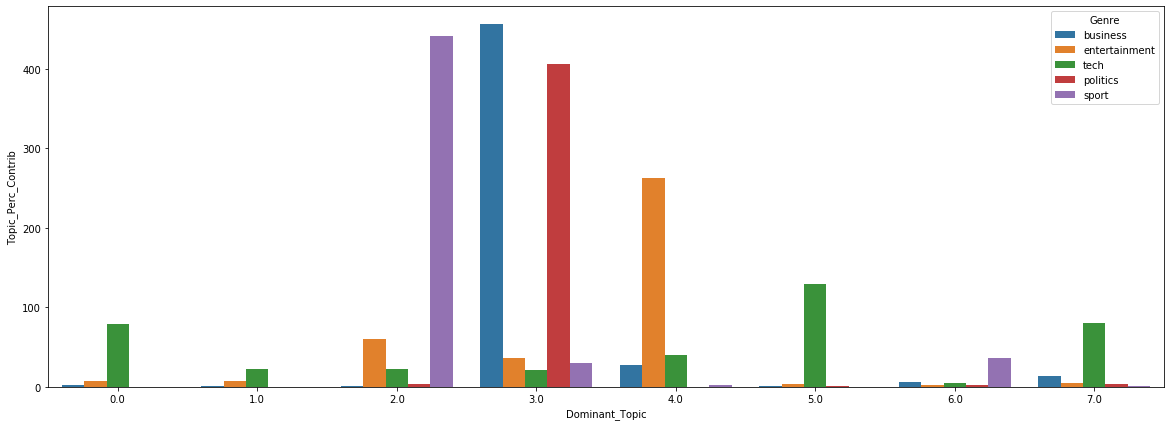

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,7))
sns.barplot(x=topics.Dominant_Topic, y="Topic_Perc_Contrib", hue='Genre',data=topics)
#plt.savefig('../../Bilder/Topic Modeling/topic_modelling_verteilung')
plt.show()

In [56]:
for i, v in Counter(df_dominant_topic[df_dominant_topic.Genre=='tech'].Dominant_Topic).items():
    print(f"Topic {i} tritt {v} mal auf")

Topic 3.0 tritt 21 mal auf
Topic 5.0 tritt 130 mal auf
Topic 4.0 tritt 40 mal auf
Topic 1.0 tritt 23 mal auf
Topic 7.0 tritt 80 mal auf
Topic 0.0 tritt 79 mal auf
Topic 2.0 tritt 23 mal auf
Topic 6.0 tritt 5 mal auf


### Repräsentativstes Dokument pro Topic

In [57]:
import numpy as np
representative = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    representative = pd.concat([representative, grp.sort_values(['Perc_Contribution']).head(1)], axis=0)
representative.reset_index(drop=True, inplace=True)

representative.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text", "Genre", "Filename"
]
representative

,Topic_Number,Contribution_Perc,Keywords,Text,Genre,Filename
0,0.0,0.3114,"music, technology, TV, new, are_are, digital, ...",long hard next few efficient congenial own con...,business,243.txt
1,1.0,0.2519,"music, public, are_are, project, world, other,...",online many willing interested critical big sm...,tech,099.txt
2,2.0,0.2497,"game, time, first, world, last, good, year, ga...",top Scottish Asian other same first same deter...,entertainment,104.txt
3,3.0,0.2918,"government, %, year, new, last, public, party,...",other popular lost Many absolute huge huge chi...,entertainment,213.txt
4,4.0,0.2246,"year, new, film, first, last, world, market, s...",nude fictional worth non - essential nude uncu...,entertainment,080.txt
5,5.0,0.2873,"net, software, information, system, such, comp...",due preventative minor faulty minor minor prev...,tech,015.txt
6,6.0,0.3187,"club, %, search, team, new, deal, other, bid, ...",Arsenal full full new due new current first fe...,business,271.txt
7,7.0,0.2974,"mobile, phone, %, technology, year, broadband,...",Previous rapid accurate other electronic large...,tech,166.txt


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cv = CountVectorizer(max_features=2000, min_df=1, max_df=300, stop_words='english')
cv.fit(representative['Keywords'])

results = cv.transform(representative['Keywords'])

features = cv.get_feature_names()

In [59]:
df_res = pd.DataFrame(results.toarray(), columns=features)
# df_res = df_res.set_index(df.genre1)
df_res

,are_are,bid,broadband,club,company,computer,console,content,country,deal,...,software,team,technology,time,tv,use,way,week,world,year
0,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,1
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,1,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
7,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [60]:
df_res.loc['sum']=df_res.sum()
df_res = df_res.div(df_res.sum(axis=1), axis=0)
df_res.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
df_res

,new,are_are,year,world,computer,way,music,public,technology,information,...,film,game,gaming,good,government,high,market,mobile,bid,net
0,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
1,0.111111,0.111111,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000,0.111111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.125000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.142857,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
5,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
6,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000
7,0.125000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000
sum,0.095238,0.063492,0.063492,0.047619,0.031746,0.031746,0.031746,0.031746,0.031746,0.031746,...,0.015873,0.015873,0.015873,0.015873,0.015873,0.015873,0.015873,0.015873,0.015873,0.015873


In [61]:
genre = df_res[df_res.index==5]
genre.loc['sum']=genre.sum()
genre = genre.div(genre.sum(axis=1), axis=0)
genre.sort_values(by=['sum'], axis=1, inplace=True, ascending=False)
genre

,net,are_are,computer,security,information,software,election,company,console,content,...,phone,week,project,sale,search,party,team,time,tv,use
5,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


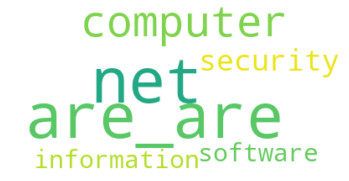

In [66]:
from wordcloud import WordCloud

def makeImage(text, figname):
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(figname)
    plt.show()

text = genre.loc['sum']
# text = abba.any()
makeImage(text, "../../Bilder/Topic Modeling/wordcloud_Topic7")